## Question 1: Predict the number of order days

### Import and install

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Load datasets

In [93]:
from google.colab import files
uploaded = files.upload()

Saving august_total_sales.parquet to august_total_sales (1).parquet
Saving august_with_missing_order_days.parquet to august_with_missing_order_days (1).parquet


In [3]:
historical_df = pd.read_parquet("historical_orders.parquet", engine='pyarrow')
historical_df.head()

,account_id,order_date,transaction_amount
0,BR_09607801000194,2021-08-28,11011.2
1,BR_09607801000194,2021-08-28,13764.0
2,BR_09607801000194,2021-08-28,11011.2
3,BR_09607801000194,2021-08-28,11011.2
4,BR_09607801000194,2021-08-28,13764.0


In [94]:
august_partial_df = pd.read_parquet("august_with_missing_order_days.parquet")
august_partial_df.head()

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52
2,BR_09532176632,2022-08-03,24.90
3,BR_09532176632,2022-08-03,28.50
4,BR_09532176632,2022-08-03,11.16


In [95]:
august_forecast_df = pd.read_parquet("august_total_sales.parquet")
august_forecast_df.head()

,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98
2,BR_00001760106,11976.70
3,BR_00002485176,511.48
4,BR_00002536340,7081.14


### Functions

In [6]:
def format_suffix(n):
    if n >= 1_000_000:
        return f'{n/1_000_000:.0f}M'
    elif n >= 1_000:
        return f'{n/1_000:.0f}K'
    else:
        return str(n)

In [7]:
def plot_time_series(data, x_column, y_column, x_label, y_label, title):
  plt.figure(figsize=(10, 5))
  plt.plot(data[x_column], data[y_column], marker='o')
  plt.title(title)
  plt.xlabel(x_label)
  plt.ylabel(y_label)

  for x, y in zip(data[x_column], data[y_column]):
    #plt.text(x, y, str(y), ha='center', va='bottom', fontsize=9)
    #plt.text(x, y, f'{(y/1_000):.0f}K', ha='center', va='bottom', fontsize=9)
    plt.text(x, y, format_suffix(y), ha='center', va='bottom', fontsize=9)

  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [8]:
def label_order_period(day):
    if day <= 10:
        return 1
    elif day <= 20:
        return 2
    else:
        return 3

### Exploratory Data Analysis

In [9]:
historical_df.shape

(8596877, 3)

In [10]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8596877 entries, 0 to 9397113
Data columns (total 3 columns):
 #   Column              Dtype  
---  ------              -----  
 0   account_id          object 
 1   order_date          object 
 2   transaction_amount  float64
dtypes: float64(1), object(2)
memory usage: 262.4+ MB


In [11]:
# Number of null data
historical_df.isnull().sum()

,0
account_id,0
order_date,0
transaction_amount,0


In [12]:
# Data duplicates
historical_df[historical_df.duplicated()]

,account_id,order_date,transaction_amount
2,BR_09607801000194,2021-08-28,11011.20
3,BR_09607801000194,2021-08-28,11011.20
4,BR_09607801000194,2021-08-28,13764.00
5,BR_09607801000194,2021-08-28,13764.00
15,BR_00481601562,2022-06-18,23.00
...,...,...,...
9397072,BR_19491957000106,2022-05-03,22.24
9397073,BR_19491957000106,2022-05-03,22.24
9397074,BR_19491957000106,2022-05-03,22.24
9397076,BR_19491957000106,2022-05-03,22.24


In [13]:
print(f'Number of duplicated: {historical_df.duplicated().sum()}')

Number of duplicated: 841462


In [14]:
# Delete duplicated
historical_df.drop_duplicates(inplace=True)
print(f'Number of duplicated: {historical_df.duplicated().sum()}')

Number of duplicated: 0


In [15]:
historical_df.shape

(7755415, 3)

In [16]:
# Disables scientific notation
pd.options.display.float_format = '{:.2f}'.format

In [17]:
historical_df.describe()

,transaction_amount
count,7755415.00
mean,280.95
std,1176.80
min,-607.50
25%,36.00
50%,89.84
75%,209.80
max,418578.92


In [18]:
print(f'The minimum date is {historical_df.order_date.min()} and maximum date\
 is {historical_df.order_date.max()}.')

The minimum date is 2021-01-02 and maximum date is 2022-07-31.


In [19]:
# Change type of order_date
historical_df['order_date'] = pd.to_datetime(
    historical_df['order_date'], errors='coerce')
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7755415 entries, 0 to 9397113
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   account_id          object        
 1   order_date          datetime64[ns]
 2   transaction_amount  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 236.7+ MB


In [20]:
# Number of unique users
historical_df.account_id.nunique()

47899

In [21]:
# Number of total orders per user per month
order_per_user = historical_df.groupby('account_id')['order_date'].count(
    ).sort_values(ascending = False).reset_index(
        name='total_order')
order_per_user.head(10)

,account_id,total_order
0,BR_33444366000109,5970
1,BR_14517343000132,5573
2,BR_30179280000108,5361
3,BR_37887177000161,5125
4,BR_27873143000164,5020
5,BR_26312477000104,4391
6,BR_27445786000107,4135
7,BR_34760676000103,4060
8,BR_37657197002009,4033
9,BR_55967699000236,3823


In [22]:
order_per_user.total_order.describe()

,total_order
count,47899.00
mean,161.91
std,266.59
min,1.00
25%,22.00
50%,73.00
75%,190.00
max,5970.00


In [23]:
# Create a new column order_month
historical_df['order_month'] = historical_df['order_date'].dt.to_period('M')
historical_df.head(2)

,account_id,order_date,transaction_amount,order_month
0,BR_09607801000194,2021-08-28,11011.20,2021-08
1,BR_09607801000194,2021-08-28,13764.00,2021-08


In [24]:
# Number of total orders per user historically
orders_per_user_month = (historical_df.groupby(['account_id', 'order_month'])
      .size()
      .reset_index(name='monthly_orders'))
orders_per_user_month

,account_id,order_month,monthly_orders
0,BR_00000343803,2021-01,7
1,BR_00000343803,2021-02,4
2,BR_00000343803,2021-03,6
3,BR_00000343803,2021-04,4
4,BR_00000343803,2021-05,8
...,...,...,...
416386,BR_99946866587,2022-05,6
416387,BR_99946866587,2022-06,8
416388,BR_99946866587,2022-07,12
416389,BR_99980878134,2021-05,13


In [25]:
orders_per_user_month.monthly_orders.describe()

,monthly_orders
count,416391.00
mean,18.63
std,21.77
min,1.00
25%,6.00
50%,12.00
75%,23.00
max,710.00


<Axes: ylabel='Frequency'>

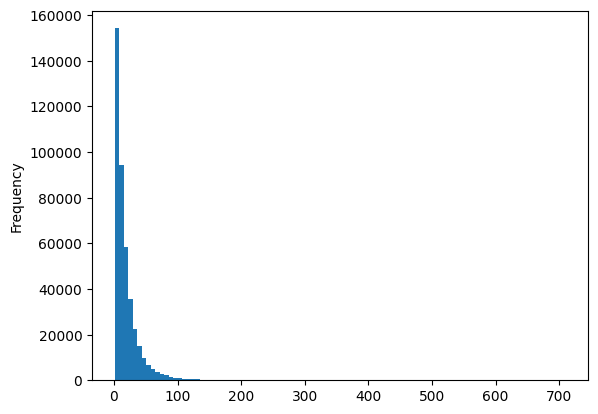

In [26]:
orders_per_user_month['monthly_orders'].plot.hist(bins=100)

<Axes: >

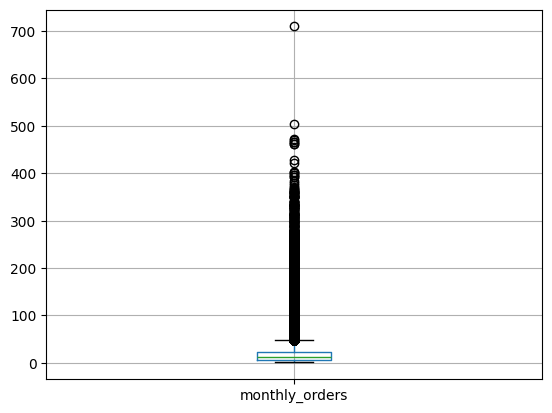

In [27]:
orders_per_user_month.boxplot(column='monthly_orders')

In [28]:
# Number of orders per month
monthly_orders = historical_df.groupby(historical_df['order_date']
    .dt.to_period('M')).size().reset_index(name='total_orders')
monthly_orders

,order_date,total_orders
0,2021-01,281854
1,2021-02,263996
2,2021-03,269064
3,2021-04,262868
4,2021-05,294883
5,2021-06,305589
6,2021-07,332317
7,2021-08,364373
8,2021-09,385784
9,2021-10,550570


In [29]:
monthly_orders['order_date'] = monthly_orders['order_date'].dt.to_timestamp()

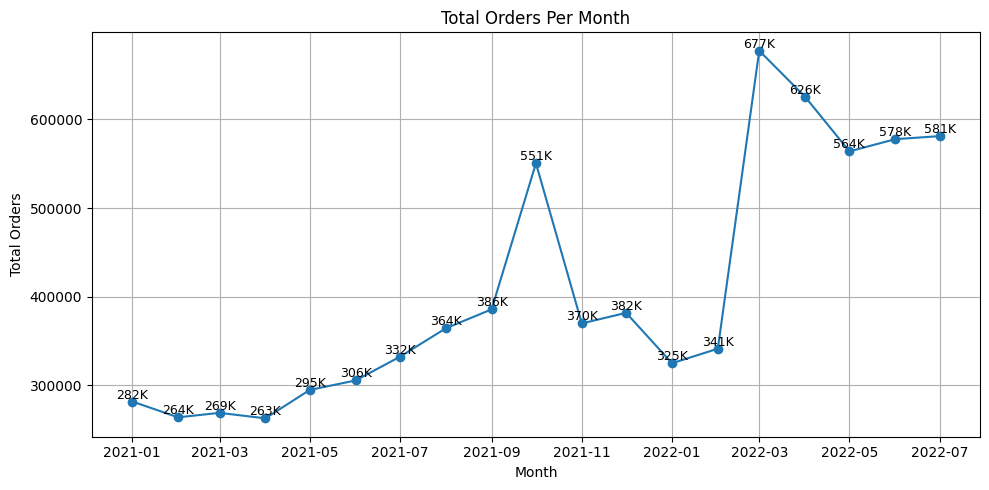

In [30]:
plot_time_series(monthly_orders, 'order_date', 'total_orders', 'Month', 'Total Orders', 'Total Orders Per Month')

In [31]:
# Number of total orders per user per day historically
orders_per_user_day = (historical_df.groupby(['account_id', 'order_date'])
      .size().sort_values(ascending=False)
      .reset_index(name='day_orders'))
orders_per_user_day.head(10)

,account_id,order_date,day_orders
0,BR_37657197003757,2021-12-30,141
1,BR_40666652000184,2022-07-20,129
2,BR_39568816000151,2022-03-24,111
3,BR_37657197003838,2022-01-03,106
4,BR_39477115000107,2022-05-17,100
5,BR_00127427000155,2022-06-11,94
6,BR_39568816000151,2022-02-23,93
7,BR_37657197005024,2021-12-22,89
8,BR_21895647000107,2021-11-04,88
9,BR_37657197003838,2022-07-05,88


In [32]:
orders_per_user_day.day_orders.describe()

,day_orders
count,1428384.00
mean,5.43
std,5.11
min,1.00
25%,2.00
50%,4.00
75%,7.00
max,141.00


<Axes: ylabel='Frequency'>

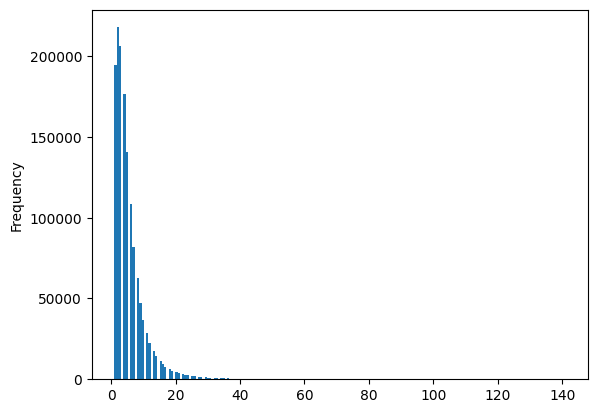

In [33]:
orders_per_user_day['day_orders'].plot.hist(bins=200)

<Axes: >

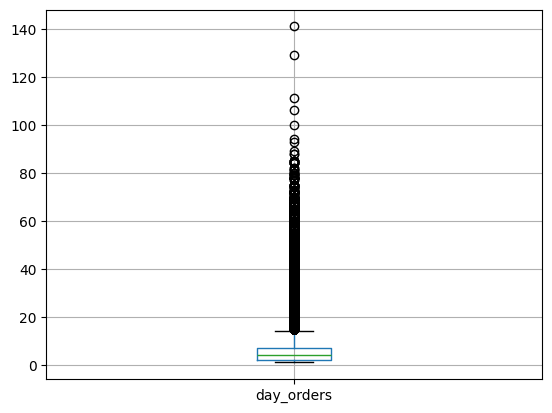

In [34]:
orders_per_user_day.boxplot(column='day_orders')

In [35]:
# Number of distinct days with orders per month historically
distinct_days_per_month = (
    historical_df.groupby('order_month')['order_date']
    .nunique()
    .reset_index(name='distinct_order_days')
)
distinct_days_per_month

,order_month,distinct_order_days
0,2021-01,25
1,2021-02,24
2,2021-03,27
3,2021-04,25
4,2021-05,26
5,2021-06,26
6,2021-07,27
7,2021-08,26
8,2021-09,27
9,2021-10,27


In [36]:
distinct_days_per_month['order_month'] = distinct_days_per_month[
    'order_month'].dt.to_timestamp()

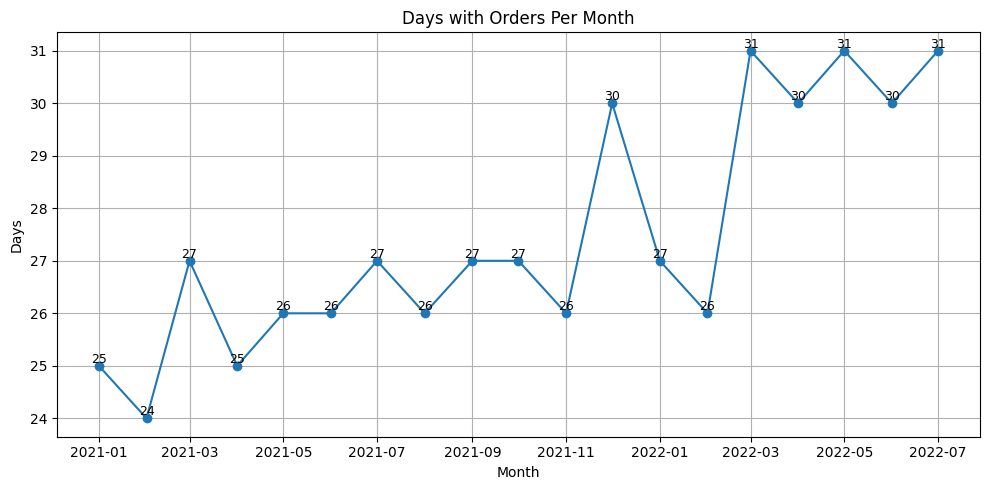

In [37]:
plot_time_series(distinct_days_per_month,
  'order_month', 'distinct_order_days', 'Month',
  'Days', 'Days with Orders Per Month')

In [38]:
historical_df.transaction_amount.describe()

,transaction_amount
count,7755415.00
mean,280.95
std,1176.80
min,-607.50
25%,36.00
50%,89.84
75%,209.80
max,418578.92


In [39]:
# Verify negative numbers in transaction_amount
historical_df[historical_df[
    'transaction_amount']<0].value_counts(
    'transaction_amount').sum()

np.int64(16740)

In [40]:
# Replace negative number with average of total_transaction_amount_august
mean_value = historical_df.loc[historical_df[
  'transaction_amount'] >= 0,
  'transaction_amount'].mean()
historical_df.loc[historical_df['transaction_amount'] < 0,
  'transaction_amount'] = mean_value
historical_df[historical_df[
  'transaction_amount']<0].value_counts(
  'transaction_amount')

,count
transaction_amount,


In [41]:
historical_df.describe()

,order_date,transaction_amount
count,7755415,7755415.00
mean,2021-11-28 22:21:54.619941120,281.77
min,2021-01-02 00:00:00,0.00
25%,2021-07-26 00:00:00,36.36
50%,2021-12-15 00:00:00,90.52
75%,2022-04-19 00:00:00,211.60
max,2022-07-31 00:00:00,418578.92
std,NaN,1176.67


<Axes: >

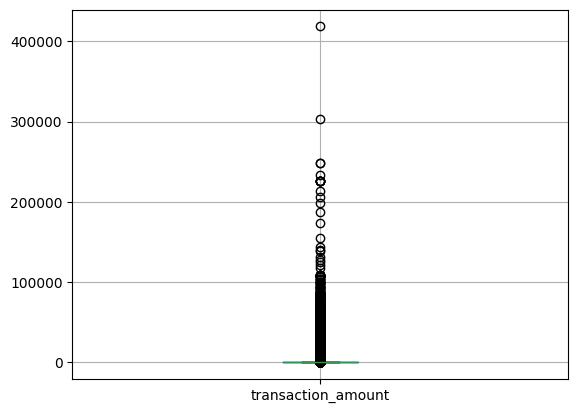

In [42]:
historical_df.boxplot('transaction_amount')

In [43]:
historical_df.head(2)

,account_id,order_date,transaction_amount,order_month
0,BR_09607801000194,2021-08-28,11011.20,2021-08
1,BR_09607801000194,2021-08-28,13764.00,2021-08


In [44]:
# Total transaction amount per month
monthly_transactions_amount = historical_df.groupby('order_month')[
    'transaction_amount'].sum().reset_index(name='total_transactions_amount')
monthly_transactions_amount

,order_month,total_transactions_amount
0,2021-01,93537556.63
1,2021-02,77562704.15
2,2021-03,75484718.14
3,2021-04,76831850.76
4,2021-05,84814918.45
5,2021-06,78221863.89
6,2021-07,86863637.62
7,2021-08,95755875.28
8,2021-09,117842710.11
9,2021-10,149277371.82


In [45]:
monthly_transactions_amount.order_month.info()

<class 'pandas.core.series.Series'>
RangeIndex: 19 entries, 0 to 18
Series name: order_month
Non-Null Count  Dtype    
--------------  -----    
19 non-null     period[M]
dtypes: period[M](1)
memory usage: 284.0 bytes


In [46]:
distinct_days_per_month.order_month.info()

<class 'pandas.core.series.Series'>
RangeIndex: 19 entries, 0 to 18
Series name: order_month
Non-Null Count  Dtype         
--------------  -----         
19 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 284.0 bytes


In [47]:
# Convert order_month to timestamp
monthly_transactions_amount['order_month'] = monthly_transactions_amount['order_month'].dt.to_timestamp()
monthly_transactions_amount.order_month.info()

<class 'pandas.core.series.Series'>
RangeIndex: 19 entries, 0 to 18
Series name: order_month
Non-Null Count  Dtype         
--------------  -----         
19 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 284.0 bytes


In [48]:
# Combine into a single DataFrame
monthly_analysis = pd.merge(
    monthly_transactions_amount,
    distinct_days_per_month,
    on='order_month'
)
monthly_analysis.head(2)

,order_month,total_transactions_amount,distinct_order_days
0,2021-01-01,93537556.63,25
1,2021-02-01,77562704.15,24


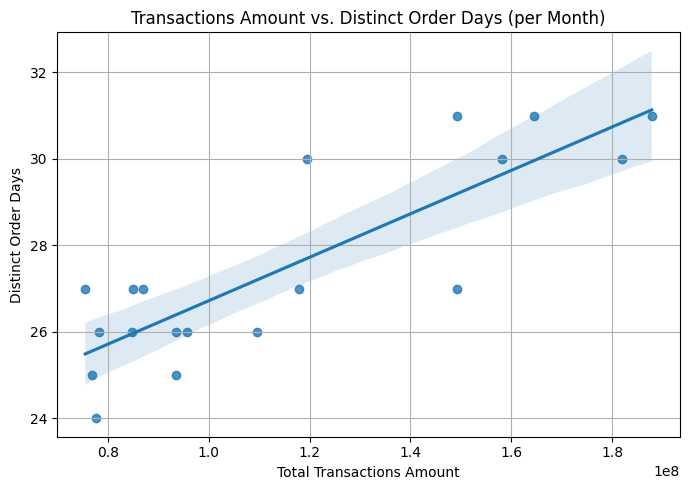

In [49]:
plt.figure(figsize=(7, 5))
sns.regplot(data=monthly_analysis,
    x='total_transactions_amount', y='distinct_order_days')
plt.title('Transactions Amount vs. Distinct Order Days (per Month)')
plt.xlabel('Total Transactions Amount')
plt.ylabel('Distinct Order Days')
plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
correlation = monthly_analysis[['total_transactions_amount', 'distinct_order_days']].corr().iloc[0,1]
print(f'Correlation: {correlation:.2f}')

Correlation: 0.84


### Feature Engineering

#### Process historical_df

In [51]:
historical_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7755415 entries, 0 to 9397113
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   account_id          object        
 1   order_date          datetime64[ns]
 2   transaction_amount  float64       
 3   order_month         period[M]     
dtypes: datetime64[ns](1), float64(1), object(1), period[M](1)
memory usage: 295.8+ MB


In [52]:
historical_df.head(10)

,account_id,order_date,transaction_amount,order_month
0,BR_09607801000194,2021-08-28,11011.20,2021-08
1,BR_09607801000194,2021-08-28,13764.00,2021-08
6,BR_00481601562,2022-06-18,1017.00,2022-06
7,BR_00481601562,2022-06-18,244.20,2022-06
8,BR_00481601562,2022-06-18,23.00,2022-06
9,BR_00481601562,2022-06-18,42.92,2022-06
10,BR_00481601562,2022-06-18,20.88,2022-06
11,BR_00481601562,2022-06-18,46.00,2022-06
12,BR_00481601562,2022-06-18,28.68,2022-06
13,BR_00481601562,2022-06-18,31.68,2022-06


In [53]:
# Create dataframe with target
grouped = historical_df.groupby(['account_id', 'order_month'])

target_rows = []

for (user, month), group in grouped:
    ordered_days = sorted(group['order_date'].dt.date.unique())

    for i, current_day in enumerate(ordered_days):
        remaining_days = len(ordered_days) - (i + 1)

        target_rows.append({
            'account_id': user,
            'order_date': current_day,
            'order_month': month,
            'orders_so_far': i + 1,
            'target': remaining_days
        })

target_df = pd.DataFrame(target_rows)
target_df

,account_id,order_date,order_month,orders_so_far,target
0,BR_00000343803,2021-01-07,2021-01,1,3
1,BR_00000343803,2021-01-14,2021-01,2,2
2,BR_00000343803,2021-01-21,2021-01,3,1
3,BR_00000343803,2021-01-30,2021-01,4,0
4,BR_00000343803,2021-02-11,2021-02,1,1
...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,2021-05,3,0
1428380,BR_99980878134,2021-06-07,2021-06,1,3
1428381,BR_99980878134,2021-06-10,2021-06,2,2
1428382,BR_99980878134,2021-06-12,2021-06,3,1


In [54]:
target_df[target_df['account_id']=='BR_00000343803']

,account_id,order_date,order_month,orders_so_far,target
0,BR_00000343803,2021-01-07,2021-01,1,3
1,BR_00000343803,2021-01-14,2021-01,2,2
2,BR_00000343803,2021-01-21,2021-01,3,1
3,BR_00000343803,2021-01-30,2021-01,4,0
4,BR_00000343803,2021-02-11,2021-02,1,1
5,BR_00000343803,2021-02-18,2021-02,2,0
6,BR_00000343803,2021-03-04,2021-03,1,2
7,BR_00000343803,2021-03-20,2021-03,2,1
8,BR_00000343803,2021-03-25,2021-03,3,0
9,BR_00000343803,2021-04-15,2021-04,1,0


In [55]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype    
---  ------         --------------    -----    
 0   account_id     1428384 non-null  object   
 1   order_date     1428384 non-null  object   
 2   order_month    1428384 non-null  period[M]
 3   orders_so_far  1428384 non-null  int64    
 4   target         1428384 non-null  int64    
dtypes: int64(2), object(2), period[M](1)
memory usage: 54.5+ MB


In [56]:
# Convert order_date is datetime
target_df['order_date'] = pd.to_datetime(target_df['order_date'])
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 5 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   account_id     1428384 non-null  object        
 1   order_date     1428384 non-null  datetime64[ns]
 2   order_month    1428384 non-null  period[M]     
 3   orders_so_far  1428384 non-null  int64         
 4   target         1428384 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1), period[M](1)
memory usage: 54.5+ MB


In [166]:
# Group transactions by day per user
grouped_df = (
    historical_df.groupby(['account_id', 'order_date'])
    .agg(transaction_amount=('transaction_amount', 'sum'))
    .reset_index()
)
grouped_df

,account_id,order_date,transaction_amount
0,BR_00000343803,2021-01-07,252.88
1,BR_00000343803,2021-01-14,49.52
2,BR_00000343803,2021-01-21,173.96
3,BR_00000343803,2021-01-30,338.56
4,BR_00000343803,2021-02-11,111.20
...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02
1428380,BR_99980878134,2021-06-07,139.30
1428381,BR_99980878134,2021-06-10,36.96
1428382,BR_99980878134,2021-06-12,76.36


In [167]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 3 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   account_id          1428384 non-null  object        
 1   order_date          1428384 non-null  datetime64[ns]
 2   transaction_amount  1428384 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 32.7+ MB


In [168]:
# Merge dataframes
processed_historical_df = pd.merge(grouped_df, target_df,
  on=['account_id','order_date'], how='inner')
processed_historical_df.head(2)

,account_id,order_date,transaction_amount,order_month,orders_so_far,target
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2


In [169]:
# Create a new column with average number of order days per month per user
processed_historical_df['avg_order_days_per_month'] = processed_historical_df.groupby(
  'account_id')['order_date'].transform('nunique')/processed_historical_df.groupby(
  'account_id')['order_month'].transform('nunique')
processed_historical_df.head()

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79


In [170]:
processed_historical_df.avg_order_days_per_month.describe()

,avg_order_days_per_month
count,1428384.00
mean,4.33
std,2.31
min,1.00
25%,2.84
50%,3.79
75%,5.26
max,21.58


In [171]:
# Create a new column to compute the frequency of order days
processed_historical_df.sort_values(by=['account_id', 'order_date'], inplace=True)
processed_historical_df.reset_index(drop=True, inplace=True)
processed_historical_df['days_since_last_order'] = processed_historical_df.groupby('account_id')[
    'order_date'].diff().dt.days
processed_historical_df

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,days_since_last_order
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,NaN
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,7.00
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,7.00
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,9.00
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,12.00
...,...,...,...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02,2021-05,3,0,3.50,4.00
1428380,BR_99980878134,2021-06-07,139.30,2021-06,1,3,3.50,9.00
1428381,BR_99980878134,2021-06-10,36.96,2021-06,2,2,3.50,3.00
1428382,BR_99980878134,2021-06-12,76.36,2021-06,3,1,3.50,2.00


In [172]:
# Create a new column with average days betwenn orders
processed_historical_df['avg_days_between_orders'] = processed_historical_df.groupby('account_id')[
    'days_since_last_order'].transform('mean')
processed_historical_df.drop(columns='days_since_last_order', inplace=True)
processed_historical_df.head()

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,10.94
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,10.94
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,10.94


In [173]:
processed_historical_df.avg_days_between_orders.describe()

,avg_days_between_orders
count,1425110.00
mean,10.44
std,8.54
min,1.00
25%,5.96
50%,8.38
75%,12.58
max,534.00


In [174]:
# Create a new column to compute the typical order days position in the month
processed_historical_df['day_of_month'] = processed_historical_df['order_date'].dt.day
processed_historical_df

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,day_of_month
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,7
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,14
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,10.94,21
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,10.94,30
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,10.94,11
...,...,...,...,...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02,2021-05,3,0,3.50,5.00,29
1428380,BR_99980878134,2021-06-07,139.30,2021-06,1,3,3.50,5.00,7
1428381,BR_99980878134,2021-06-10,36.96,2021-06,2,2,3.50,5.00,10
1428382,BR_99980878134,2021-06-12,76.36,2021-06,3,1,3.50,5.00,12


In [175]:
# Compute average order day per user
avg_day = processed_historical_df.groupby('account_id')['day_of_month'].mean().rename('avg_order_day')
avg_day.head(15)

,avg_order_day
account_id,
BR_00000343803,16.74
BR_00001415930,13.71
BR_00001545205,14.74
BR_00001760106,13.63
BR_00002485176,13.93
BR_00002536340,14.52
BR_00003056503,16.40
BR_00003686108,14.50
BR_00005396352,15.32


In [176]:
avg_day.sort_values()

,avg_order_day
account_id,
BR_07434926252,1.00
BR_43180977000140,1.00
BR_34073575000156,1.00
BR_13609172000109,1.00
BR_45534940000107,1.00
...,...
BR_00721032052,31.00
BR_08904204402,31.00
BR_44033191000163,31.00


In [177]:
# Create labels of order days position in the month
avg_day_period = avg_day.apply(label_order_period).rename('typical_order_period')
avg_day_period.head(15)

,typical_order_period
account_id,
BR_00000343803,2
BR_00001415930,2
BR_00001545205,2
BR_00001760106,2
BR_00002485176,2
BR_00002536340,2
BR_00003056503,2
BR_00003686108,2
BR_00005396352,2


In [178]:
avg_day_period.sort_values()

,typical_order_period
account_id,
BR_01497985200,1
BR_01538686000131,1
BR_01553896530,1
BR_01551676001,1
BR_01569359000147,1
...,...
BR_09361223747,3
BR_43645996000103,3
BR_39425865000135,3


In [179]:
# Merge labels of typical order period back into original dataframe
processed_historical_df = processed_historical_df.merge(avg_day_period, on='account_id', how='left')
processed_historical_df.drop(columns='day_of_month',inplace=True)
processed_historical_df

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2
2,BR_00000343803,2021-01-21,173.96,2021-01,3,1,2.79,10.94,2
3,BR_00000343803,2021-01-30,338.56,2021-01,4,0,2.79,10.94,2
4,BR_00000343803,2021-02-11,111.20,2021-02,1,1,2.79,10.94,2
...,...,...,...,...,...,...,...,...,...
1428379,BR_99980878134,2021-05-29,160.02,2021-05,3,0,3.50,5.00,2
1428380,BR_99980878134,2021-06-07,139.30,2021-06,1,3,3.50,5.00,2
1428381,BR_99980878134,2021-06-10,36.96,2021-06,2,2,3.50,5.00,2
1428382,BR_99980878134,2021-06-12,76.36,2021-06,3,1,3.50,5.00,2


In [180]:
processed_historical_df[
    processed_historical_df['account_id'] == 'BR_00008414122']

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period
288,BR_00008414122,2021-10-30,455.62,2021-10,1,0,1.00,NaN,3


In [181]:
processed_historical_df[
    processed_historical_df['account_id'] == 'BR_08141858432']

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period
330824,BR_08141858432,2021-01-06,326.70,2021-01,1,1,2.00,3.00,1
330825,BR_08141858432,2021-01-09,95.00,2021-01,2,0,2.00,3.00,1


In [182]:
processed_historical_df['avg_days_between_orders']= processed_historical_df[
    'avg_days_between_orders'].fillna(0)
processed_historical_df[
    processed_historical_df['account_id'] == 'BR_00008414122']

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period
288,BR_00008414122,2021-10-30,455.62,2021-10,1,0,1.00,0.00,3


In [183]:
processed_historical_df.isnull().sum()

,0
account_id,0
order_date,0
transaction_amount,0
order_month,0
orders_so_far,0
target,0
avg_order_days_per_month,0
avg_days_between_orders,0
typical_order_period,0


In [184]:
# Create column of day of month
processed_historical_df["day"] = processed_historical_df[
    "order_date"].dt.day
processed_historical_df.head(2)

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,day
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2,7
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2,14


In [185]:
# Create column of month
processed_historical_df["month"] = processed_historical_df[
    "order_date"].dt.month
processed_historical_df.head(2)

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,day,month
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2,7,1
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2,14,1


In [186]:
# Create column of year
processed_historical_df["year"] = processed_historical_df[
    "order_date"].dt.year
processed_historical_df.head(2)

,account_id,order_date,transaction_amount,order_month,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,day,month,year
0,BR_00000343803,2021-01-07,252.88,2021-01,1,3,2.79,10.94,2,7,1,2021
1,BR_00000343803,2021-01-14,49.52,2021-01,2,2,2.79,10.94,2,14,1,2021


In [187]:
processed_historical_df.drop(columns=[
    'order_date', 'order_month'], inplace=True)
processed_historical_df

,account_id,transaction_amount,orders_so_far,target,avg_order_days_per_month,avg_days_between_orders,typical_order_period,day,month,year
0,BR_00000343803,252.88,1,3,2.79,10.94,2,7,1,2021
1,BR_00000343803,49.52,2,2,2.79,10.94,2,14,1,2021
2,BR_00000343803,173.96,3,1,2.79,10.94,2,21,1,2021
3,BR_00000343803,338.56,4,0,2.79,10.94,2,30,1,2021
4,BR_00000343803,111.20,1,1,2.79,10.94,2,11,2,2021
...,...,...,...,...,...,...,...,...,...,...
1428379,BR_99980878134,160.02,3,0,3.50,5.00,2,29,5,2021
1428380,BR_99980878134,139.30,1,3,3.50,5.00,2,7,6,2021
1428381,BR_99980878134,36.96,2,2,3.50,5.00,2,10,6,2021
1428382,BR_99980878134,76.36,3,1,3.50,5.00,2,12,6,2021


In [188]:
processed_historical_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1428384 entries, 0 to 1428383
Data columns (total 10 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   account_id                1428384 non-null  object 
 1   transaction_amount        1428384 non-null  float64
 2   orders_so_far             1428384 non-null  int64  
 3   target                    1428384 non-null  int64  
 4   avg_order_days_per_month  1428384 non-null  float64
 5   avg_days_between_orders   1428384 non-null  float64
 6   typical_order_period      1428384 non-null  int64  
 7   day                       1428384 non-null  int32  
 8   month                     1428384 non-null  int32  
 9   year                      1428384 non-null  int32  
dtypes: float64(3), int32(3), int64(3), object(1)
memory usage: 92.6+ MB


#### Process august_forecast_df and august_partial_df

In [96]:
august_forecast_df.head(2)

,account_id,total_transaction_amount_august
0,BR_00000343803,309.99
1,BR_00001415930,874.98


In [97]:
august_forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 2 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   account_id                       32944 non-null  object 
 1   total_transaction_amount_august  32944 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.9+ KB


In [98]:
august_forecast_df.duplicated().sum()

np.int64(0)

In [99]:
august_partial_df.head(2)

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,11.16
1,BR_09532176632,2022-08-03,32.52


In [100]:
august_partial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317735 entries, 0 to 317734
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   account_id          317735 non-null  object 
 1   order_date          304297 non-null  object 
 2   transaction_amount  304297 non-null  float64
dtypes: float64(1), object(2)
memory usage: 7.3+ MB


In [101]:
august_partial_df.duplicated().sum()

np.int64(26418)

In [102]:
# Delete duplicated
august_partial_df.drop_duplicates(inplace=True)
august_partial_df.duplicated().sum()

np.int64(0)

In [119]:
# Convert order_date is datetime
august_partial_df['order_date'] = pd.to_datetime(august_partial_df['order_date'])
august_partial_df.order_date.info()

<class 'pandas.core.series.Series'>
Index: 291317 entries, 0 to 317734
Series name: order_date
Non-Null Count   Dtype         
--------------   -----         
277879 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 4.4 MB


In [129]:
# Group transactions by day per user
grouped_august_partial_df = (
    august_partial_df.groupby(['account_id', 'order_date'])
    .agg(transaction_amount=('transaction_amount', 'sum'),)
    .reset_index()
)
grouped_august_partial_df.head(2)

,account_id,order_date,transaction_amount
0,BR_00002485176,2022-08-06,44.00
1,BR_00002485176,2022-08-13,283.98


In [121]:
grouped_august_partial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43927 entries, 0 to 43926
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_id          43927 non-null  object        
 1   order_date          43927 non-null  datetime64[ns]
 2   transaction_amount  43927 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.0+ MB


In [123]:
august_partial_df.account_id.nunique()

32944

In [124]:
grouped_august_partial_df.account_id.nunique()

19506

In [130]:
# Get unique account_ids
account_ids_aug = august_partial_df[['account_id']].drop_duplicates()
# Left join to preserve all account_ids
grouped_august_df = (
    account_ids_aug
    .merge(grouped_august_partial_df, on='account_id', how='left')
)
grouped_august_df.head(2)

,account_id,order_date,transaction_amount
0,BR_09532176632,2022-08-03,97.08
1,BR_09532176632,2022-08-04,156.54


In [131]:
grouped_august_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57365 entries, 0 to 57364
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   account_id          57365 non-null  object        
 1   order_date          43927 non-null  datetime64[ns]
 2   transaction_amount  43927 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.3+ MB


In [132]:
grouped_august_df.account_id.nunique()

32944

In [133]:
august_df = pd.merge(grouped_august_df,august_forecast_df,
  on='account_id', how='left')
august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august
0,BR_09532176632,2022-08-03,97.08,2011.36
1,BR_09532176632,2022-08-04,156.54,2011.36


In [134]:
august_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57365 entries, 0 to 57364
Data columns (total 4 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   account_id                       57365 non-null  object        
 1   order_date                       43927 non-null  datetime64[ns]
 2   transaction_amount               43927 non-null  float64       
 3   total_transaction_amount_august  57365 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 1.8+ MB


In [135]:
# Verify negative numbers in transaction_amount
august_df[august_df['transaction_amount']<0].value_counts(
    'transaction_amount')

,count
transaction_amount,
-99.00,26
-57.02,1


In [136]:
# Replace negative number with average of transaction_amount
mean_value_aug = august_df.loc[august_df[
  'transaction_amount'] >= 0,
  'transaction_amount'].mean()
august_df.loc[august_df['transaction_amount'] < 0,
  'transaction_amount'] = mean_value_aug
august_df[august_df[
  'transaction_amount']<0].value_counts(
  'transaction_amount')

,count
transaction_amount,


In [137]:
# Verify negative numbers in total_transaction_amount_august
august_df[august_df[
    'total_transaction_amount_august']<0].value_counts(
        'total_transaction_amount_august')

,count
total_transaction_amount_august,
-99.00,21
-198.00,11
-297.00,10
-396.00,7
-9108.00,6
...,...
-9.26,1
-6.30,1
-6.98,1


In [138]:
# Replace negative number with average of total_transaction_amount_august
mean_value_aug = august_df.loc[august_df[
  'total_transaction_amount_august'] >= 0,
  'total_transaction_amount_august'].mean()
august_df.loc[august_df['total_transaction_amount_august'] < 0,
  'total_transaction_amount_august'] = mean_value_aug
august_df[august_df[
  'total_transaction_amount_august']<0].value_counts(
  'total_transaction_amount_august')

,count
total_transaction_amount_august,


In [140]:
august_df.describe()

,order_date,transaction_amount,total_transaction_amount_august
count,43927,43927.00,57365.00
mean,2022-08-09 04:25:04.350399488,1832.43,12980.29
min,2022-08-01 00:00:00,0.00,0.00
25%,2022-08-03 00:00:00,284.30,984.16
50%,2022-08-08 00:00:00,658.90,2799.31
75%,2022-08-15 00:00:00,1548.11,7810.55
max,2022-08-30 00:00:00,453915.44,2638720.17
std,NaN,6053.31,79405.50


In [141]:
# Compute average spend per order day per user
avg_spend_per_day = august_df.groupby('account_id')[
    ['transaction_amount', 'order_date']
].apply(
    lambda x: x['transaction_amount'].sum() / x['order_date'].nunique()
    if x['order_date'].nunique() > 0 else np.nan
).reset_index(name='avg_spend_per_order_day')
avg_spend_per_day.head(2)

,account_id,avg_spend_per_order_day
0,BR_00000343803,NaN
1,BR_00001415930,NaN


In [142]:
avg_spend_per_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32944 entries, 0 to 32943
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   account_id               32944 non-null  object 
 1   avg_spend_per_order_day  19506 non-null  float64
dtypes: float64(1), object(1)
memory usage: 514.9+ KB


In [143]:
# Merge with august_forecast_df
processed_august_df = pd.merge(august_df, avg_spend_per_day,
    on='account_id', how='left')
processed_august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august,avg_spend_per_order_day
0,BR_09532176632,2022-08-03,97.08,2011.36,135.13
1,BR_09532176632,2022-08-04,156.54,2011.36,135.13


In [147]:
# Estimate order days using: average spend per day = total amount / order days
processed_august_df['estimated_order_days_august'] = \
  processed_august_df['total_transaction_amount_august'] / \
  processed_august_df['avg_spend_per_order_day']
processed_august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august,avg_spend_per_order_day,estimated_order_days_august
0,BR_09532176632,2022-08-03,97.08,2011.36,135.13,14.88
1,BR_09532176632,2022-08-04,156.54,2011.36,135.13,14.88


In [148]:
# Round estimated_order_days_august
processed_august_df['estimated_order_days_august'] = \
processed_august_df['estimated_order_days_august'].replace([
    np.inf, -np.inf], np.nan)
processed_august_df['estimated_order_days_august'] = \
processed_august_df['estimated_order_days_august'
  ].round().astype('Int64')
processed_august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august,avg_spend_per_order_day,estimated_order_days_august
0,BR_09532176632,2022-08-03,97.08,2011.36,135.13,15
1,BR_09532176632,2022-08-04,156.54,2011.36,135.13,15


In [151]:
# Create a column with order days partial to compute estimated days to be target
order_days_partial = (
    processed_august_df.groupby(['account_id'])
    .agg(order_days_partial=('order_date', 'nunique'))
    .reset_index()
)
order_days_partial

,account_id,order_days_partial
0,BR_00000343803,0
1,BR_00001415930,0
2,BR_00001760106,0
3,BR_00002485176,2
4,BR_00002536340,1
...,...,...
32939,BR_99904403791,0
32940,BR_99910241587,0
32941,BR_99936259300,1
32942,BR_99946866587,0


In [158]:
# Merge dataframes to compute estimated days to be target
processed_august_df = pd.merge(processed_august_df, order_days_partial,on='account_id')
processed_august_df.head(2)

,account_id,order_date,transaction_amount,total_transaction_amount_august,avg_spend_per_order_day,estimated_order_days_august,order_days_partial
0,BR_09532176632,2022-08-03,97.08,2011.36,135.13,15,5
1,BR_09532176632,2022-08-04,156.54,2011.36,135.13,15,5


In [160]:
# Create column target with estimated days
processed_august_df['target'] = processed_august_df[
    'estimated_order_days_august']-processed_august_df['order_days_partial']
processed_august_df.head(10)

,account_id,order_date,transaction_amount,total_transaction_amount_august,avg_spend_per_order_day,estimated_order_days_august,order_days_partial,target
0,BR_09532176632,2022-08-03,97.08,2011.36,135.13,15,5,10
1,BR_09532176632,2022-08-04,156.54,2011.36,135.13,15,5,10
2,BR_09532176632,2022-08-08,49.80,2011.36,135.13,15,5,10
3,BR_09532176632,2022-08-09,21.72,2011.36,135.13,15,5,10
4,BR_09532176632,2022-08-11,350.50,2011.36,135.13,15,5,10
5,BR_58837817215,2022-08-02,9696.00,123169.02,4663.97,26,14,12
6,BR_58837817215,2022-08-03,5121.66,123169.02,4663.97,26,14,12
7,BR_58837817215,2022-08-04,9123.00,123169.02,4663.97,26,14,12
8,BR_58837817215,2022-08-05,6701.00,123169.02,4663.97,26,14,12
9,BR_58837817215,2022-08-06,5067.00,123169.02,4663.97,26,14,12


In [195]:
processed_august_df.describe()

,order_date,transaction_amount,total_transaction_amount_august,avg_spend_per_order_day,estimated_order_days_august,order_days_partial,target
count,43927,43927.00,57365.00,43927.00,43893.00,57365.00,43893.00
mean,2022-08-09 04:25:04.350399488,1832.43,12980.29,1832.43,6.62,2.60,3.22
min,2022-08-01 00:00:00,0.00,0.00,0.00,0.00,0.00,-4.00
25%,2022-08-03 00:00:00,284.30,984.16,345.87,4.00,1.00,1.00
50%,2022-08-08 00:00:00,658.90,2799.31,752.23,5.00,2.00,2.00
75%,2022-08-15 00:00:00,1548.11,7810.55,1657.62,7.00,4.00,3.00
max,2022-08-30 00:00:00,453915.44,2638720.17,151685.15,2395.00,18.00,2394.00
std,NaN,6053.31,79405.50,4838.57,16.33,2.54,16.16


In [194]:
processed_august_df.estimated_order_days_august.max()

np.int64(2395)

In [191]:
processed_historical_df.avg_order_days_per_month.max()

21.57894736842105

In [110]:
processed_historical_df.columns

Index(['account_id', 'transaction_amount', 'orders_so_far', 'target',
       'avg_order_days_per_month', 'avg_days_between_orders',
       'typical_order_period', 'day', 'month', 'year'],
      dtype='object')

In [161]:
# processed_august_df.drop(columns=['order_days_partial_x',
#     'order_days_partial_y'], inplace=True)
# processed_august_df.head(1)

In [ ]:
# processed_historical_df.drop(columns=['typical_order_period'],
#                    inplace=True)
# processed_historical_df.info()

In [ ]:

# Frequency of order days (e.g., inter-arrival time).

# Typical order days position in the month (early, mid, late?).

# Sales-to-order_days ratio: If you know the forecasted total sales, you can estimate the number of days assuming a stable sales/day pattern.

